## Importing Necessary Libraries

In [1]:
import os
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

## Necessary Variables and Hyperparameters 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
root = "/app/Datasets/T2toT8-gan/t1"
files = ['{}/{}'.format(root, x) for x in os.listdir(root)]
batch_size = 64
image_size = 64
nc = 3 # number of image channels
nz = 100 # latent vector size
hid_dim = 64
epochs = 10
lr = 0.0002
beta1 = 0.5

## Custum Dataset

In [3]:
class MyDataset(Dataset):
    def __init__(self, files, transform):
        super().__init__()
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        image = Image.open(self.files[idx])
        image = self.transform(image)
        return image, torch.Tensor([0])

## Creating and Loading Dataset

In [4]:
dataset = MyDataset(files=files,
                    transform=transforms.Compose([
                            transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

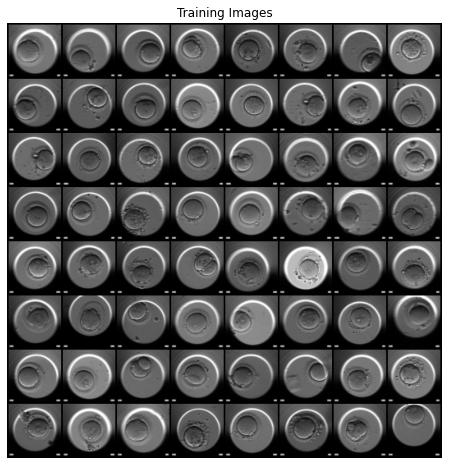

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator For Generating Fake Images From Latent Vector

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, hid_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hid_dim * 8),
            nn.ReLU(True),
            # state size. (hid_dim*8) x 4 x 4
            nn.ConvTranspose2d(hid_dim * 8, hid_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hid_dim * 4),
            nn.ReLU(True),
            # state size. (hid_dim*4) x 8 x 8
            nn.ConvTranspose2d( hid_dim * 4, hid_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hid_dim * 2),
            nn.ReLU(True),
            # state size. (hid_dim*2) x 16 x 16
            nn.ConvTranspose2d( hid_dim * 2, hid_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hid_dim),
            nn.ReLU(True),
            # state size. (hid_dim) x 32 x 32
            nn.ConvTranspose2d( hid_dim, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
gen = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
gen.apply(weights_init);

### Discriminator For Classifying Fake And Real Images

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, hid_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hid_dim) x 32 x 32
            nn.Conv2d(hid_dim, hid_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hid_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hid_dim*2) x 16 x 16
            nn.Conv2d(hid_dim * 2, hid_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hid_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hid_dim*4) x 8 x 8
            nn.Conv2d(hid_dim * 4, hid_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hid_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hid_dim*8) x 4 x 4
            nn.Conv2d(hid_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
disc = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
disc.apply(weights_init);

## Loss Function and Optimizer

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

## Training Step

In [12]:
# Lists to keep track of progress
img_list = []
gen_losses = []
disc_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        disc.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = disc(real_cpu).view(-1)
        # Calculate loss on all-real batch
        err_disc_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        err_disc_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = disc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        err_disc_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        err_disc_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        err_disc = err_disc_real + err_disc_fake
        # Update D
        opt_disc.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disc(fake).view(-1)
        # Calculate G's loss based on this output
        err_gen = criterion(output, label)
        # Calculate gradients for G
        err_gen.backward()
        D_G_z2 = output.mean().item()
        # Update G
        opt_gen.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     err_disc.item(), err_gen.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        gen_losses.append(err_gen.item())
        disc_losses.append(err_disc.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/552]	Loss_D: 1.5080	Loss_G: 4.2829	D(x): 0.5827	D(G(z)): 0.5416 / 0.0182
[0/10][50/552]	Loss_D: 0.0136	Loss_G: 7.7330	D(x): 0.9989	D(G(z)): 0.0123 / 0.0005
[0/10][100/552]	Loss_D: 0.0114	Loss_G: 11.2862	D(x): 0.9915	D(G(z)): 0.0007 / 0.0000
[0/10][150/552]	Loss_D: 0.1743	Loss_G: 33.2338	D(x): 0.9547	D(G(z)): 0.0000 / 0.0000
[0/10][200/552]	Loss_D: 0.0000	Loss_G: 40.2012	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][250/552]	Loss_D: 0.0000	Loss_G: 39.6320	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][300/552]	Loss_D: 0.0000	Loss_G: 39.4572	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][350/552]	Loss_D: 0.0000	Loss_G: 38.8971	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][400/552]	Loss_D: 0.0000	Loss_G: 38.6687	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][450/552]	Loss_D: 0.0000	Loss_G: 38.8422	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][500/552]	Loss_D: 0.0000	Loss_G: 38.7865	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][550/552]	Loss_D: 0.0000	Loss_G: 38.65

[8/10][100/552]	Loss_D: 0.4353	Loss_G: 1.9395	D(x): 0.7166	D(G(z)): 0.0447 / 0.1983
[8/10][150/552]	Loss_D: 1.2414	Loss_G: 7.7531	D(x): 0.9969	D(G(z)): 0.5963 / 0.0008
[8/10][200/552]	Loss_D: 0.2906	Loss_G: 2.3221	D(x): 0.8286	D(G(z)): 0.0764 / 0.1286
[8/10][250/552]	Loss_D: 0.5381	Loss_G: 1.8154	D(x): 0.6737	D(G(z)): 0.0319 / 0.2298
[8/10][300/552]	Loss_D: 0.1309	Loss_G: 3.5582	D(x): 0.9594	D(G(z)): 0.0720 / 0.0386
[8/10][350/552]	Loss_D: 0.7169	Loss_G: 0.7474	D(x): 0.5465	D(G(z)): 0.0141 / 0.5327
[8/10][400/552]	Loss_D: 0.2191	Loss_G: 3.6604	D(x): 0.8848	D(G(z)): 0.0765 / 0.0346
[8/10][450/552]	Loss_D: 0.1479	Loss_G: 3.5824	D(x): 0.9473	D(G(z)): 0.0824 / 0.0345
[8/10][500/552]	Loss_D: 0.3234	Loss_G: 3.5458	D(x): 0.7826	D(G(z)): 0.0418 / 0.0428
[8/10][550/552]	Loss_D: 0.3844	Loss_G: 2.2148	D(x): 0.8006	D(G(z)): 0.1168 / 0.1528
[9/10][0/552]	Loss_D: 0.1576	Loss_G: 4.3209	D(x): 0.9788	D(G(z)): 0.1215 / 0.0187
[9/10][50/552]	Loss_D: 0.0804	Loss_G: 3.8732	D(x): 0.9470	D(G(z)): 0.0231 / 0.

## Discrimator And Generator Loss Curve

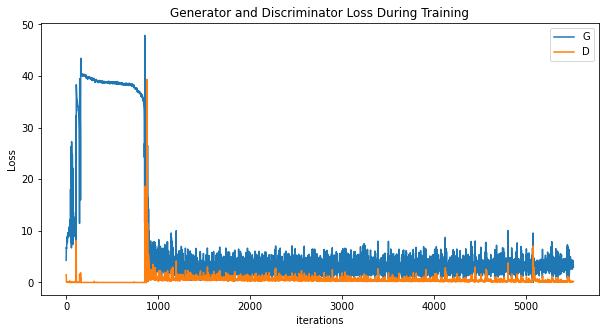

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Output From Generator Post Training

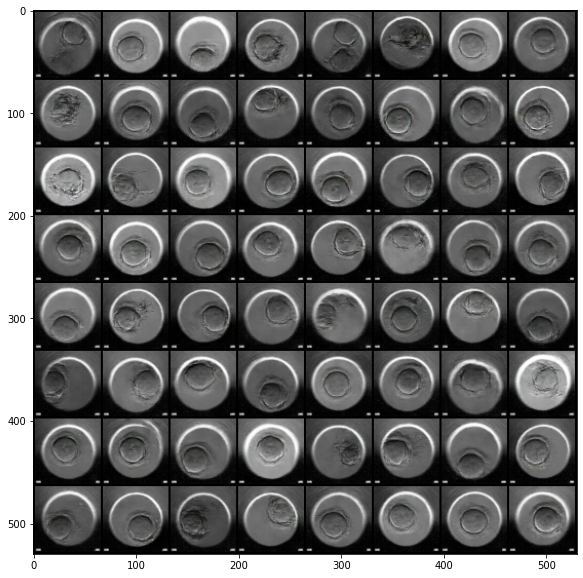

In [14]:
plt.figure(figsize=(15,10))
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)));